# Import

In [1]:
import warnings
from sklearn.exceptions import UndefinedMetricWarning

warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
from file_py.run_log_parser import RunLogParser
from file_py.csv_preprocessing_scaler_full import CsvPreprocessingScalerFull

# Preprocessing

In [3]:
df = CsvPreprocessingScalerFull.read_csv_file("file_csv/LogSplunk_12_06_Full.csv")

In [4]:
df_raw = CsvPreprocessingScalerFull.RawPreprocessing(df)

df_Le = CsvPreprocessingScalerFull.LEPreprocessing(df)
df_OH = CsvPreprocessingScalerFull.OhePreprocessing(df)

In [5]:
df_std_LE = CsvPreprocessingScalerFull.stdScaler(CsvPreprocessingScalerFull.LEPreprocessing(df))
df_std_OH = CsvPreprocessingScalerFull.stdScaler(CsvPreprocessingScalerFull.OhePreprocessing(df))

# Test

In [6]:
file_path = 'file_csv/attackLog_12_06.csv'
result_df_Le = RunLogParser.process_attacks(file_path, CsvPreprocessingScalerFull.stdScaler(CsvPreprocessingScalerFull.LEPreprocessing(df)))
result_df_OH = RunLogParser.process_attacks(file_path, CsvPreprocessingScalerFull.stdScaler(CsvPreprocessingScalerFull.OhePreprocessing(df)))

# Graphic Analysis of Attack

In [7]:
from file_py.plots import Plots

In [8]:
result_df_Raw = RunLogParser.process_attacks(file_path, CsvPreprocessingScalerFull.RawPreprocessing(df))

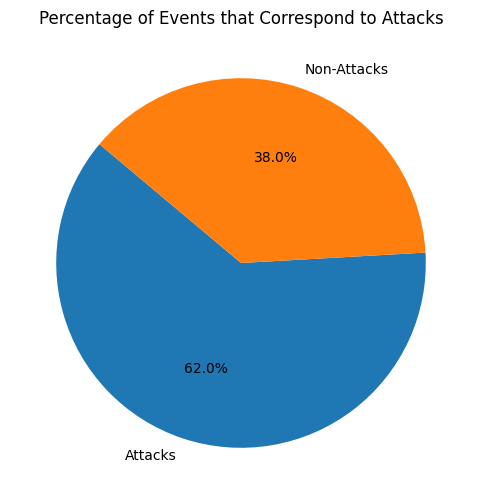

In [9]:
Plots.plot_cake_attack(result_df_Raw)

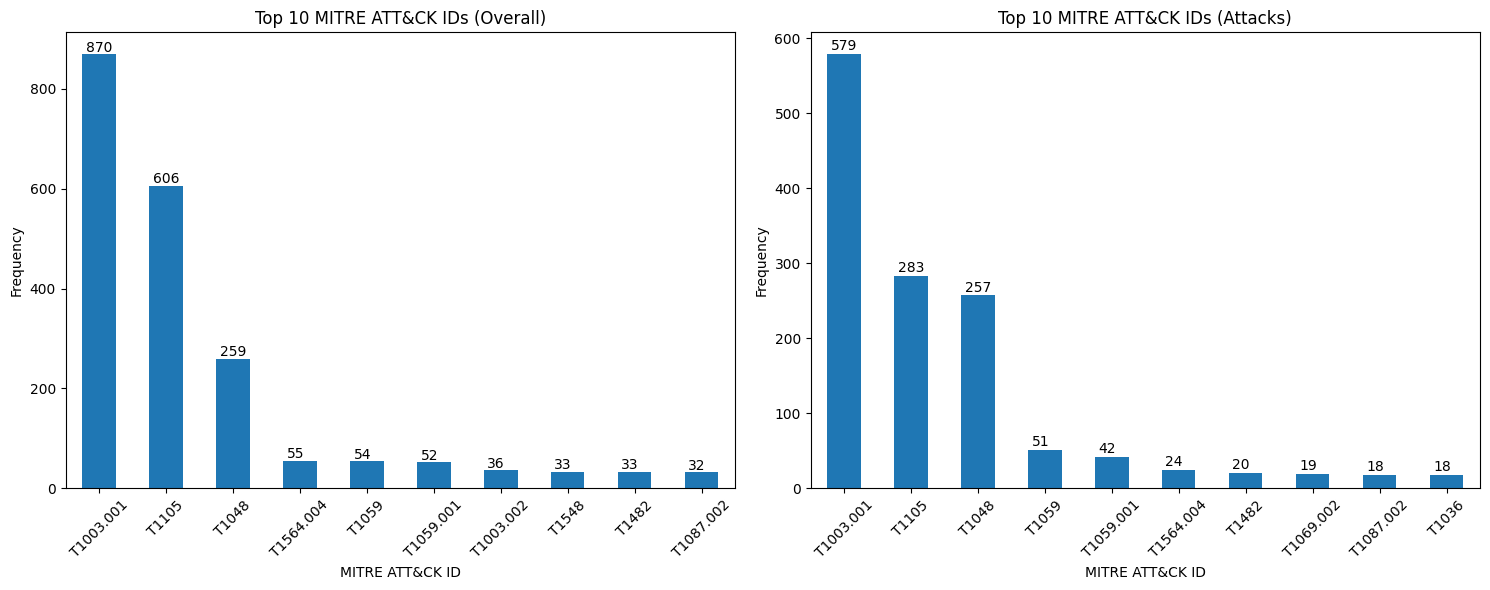

In [10]:
Plots.plot_top_10_mitre_id(result_df_Raw)

Qui si può notare come generalmente le __regole scattate più volte__ sono anche quelle che hanno effettivamente __risposto a più attachi__.  
Tra le regole presenti nella prima tabella solo __T1003.002__ e __T1548__ NON si trovano nella seconda.

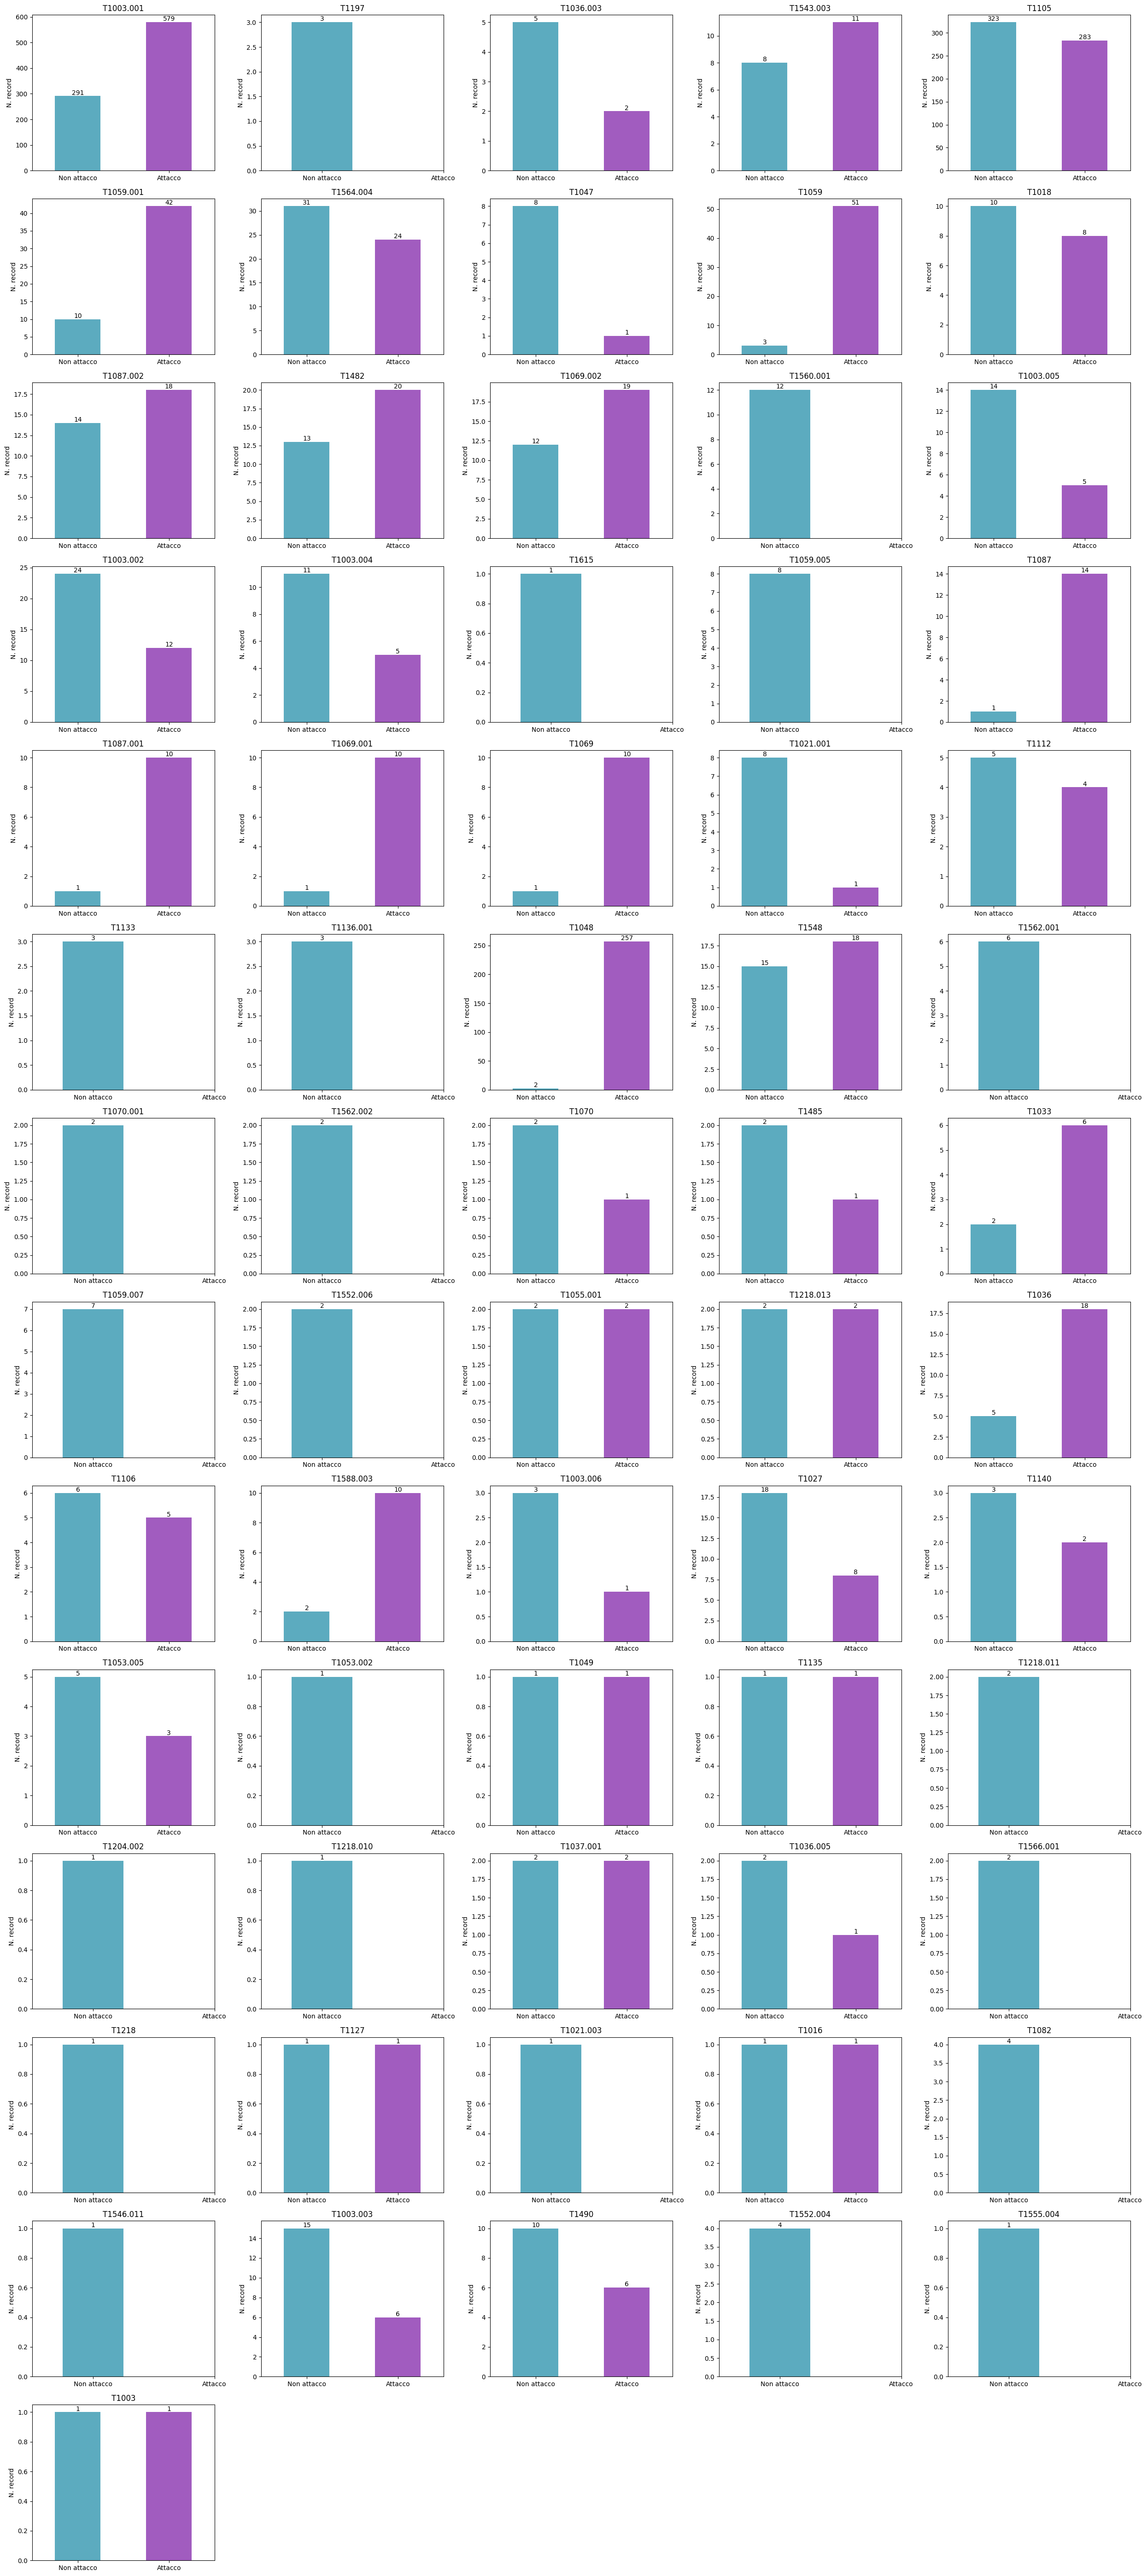

In [11]:
Plots.plot_value_counts_per_unique(result_df_Raw)

Grazie a questo grafico invece possiamo giungere ad una serie di conclusioni.  
Su __66__ regole diverse:  
- quelle scattate in risposta ad ALMENO un attacco reale sono __44__.  
Le __22__ regole che si sono attivate senza rispondere ad attacchi sono:  
T1555.004, T1552.004, T1546.011, T1082, T1021.003, T1218, T1566.001, T1218.010, T1204.002, T1218.011, T1053.002, T1552.006, T1059.007, T1070.001, T1562.002, T1562.001, T1136.001, T1133, T1059.005, T1615, T1560.001, T1197

- delle 44 in risposta ad attacchi reali:  
    - __20__ si sono attivate più volte per __non-attacchi__ rispetto che per gli attacchi
    - __8__ si sono attivate lo __stesso numero__ di volte per attacchi e non-attacchi
    - __16__ si sono attivate più volte in risposta ad __attacchi__ rispetto che a non-attacchi

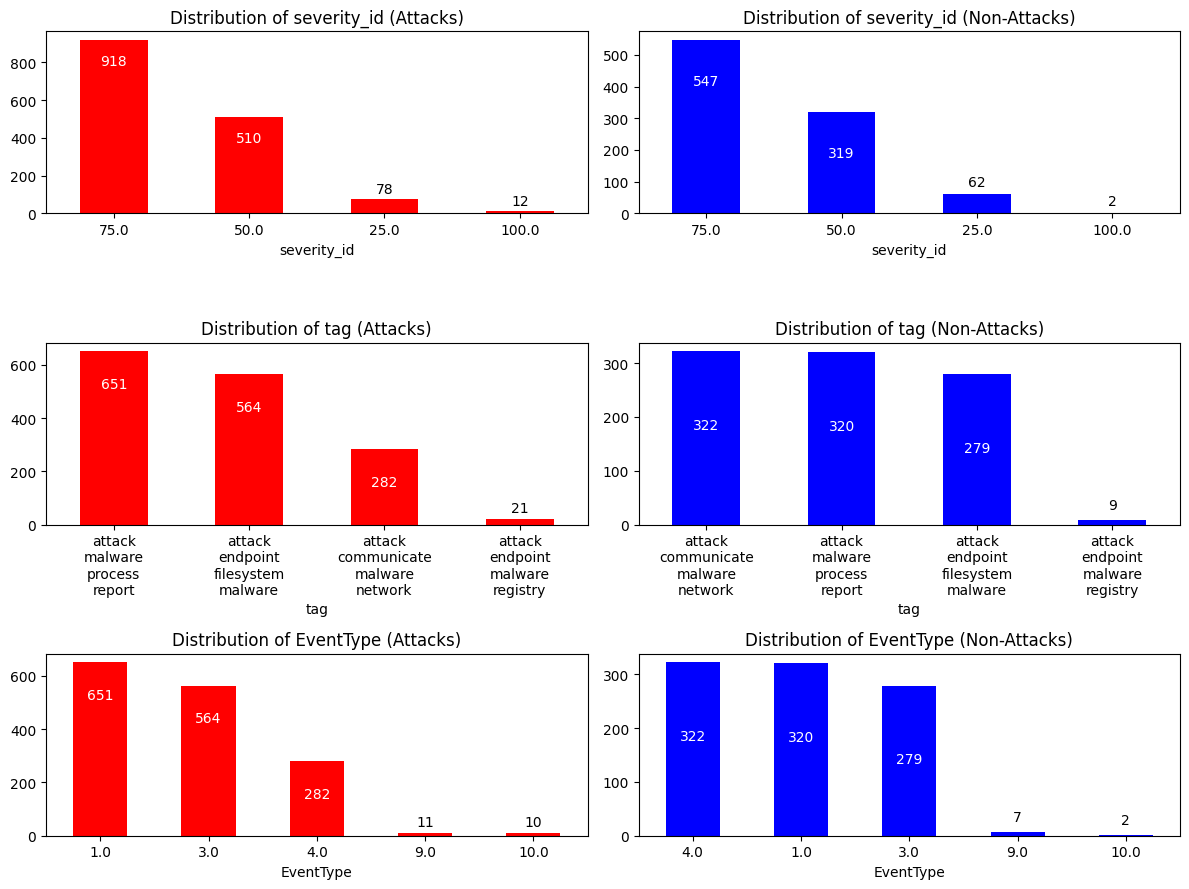

In [12]:
Plots.plot_distributions(result_df_Raw)

In questo grafico invece notiamo che la distribuzione tra attacchi e non-attacchi:
- secondo il "__severity_id__" rimane __stabile__;
- secondo il "__tag__" rimane stabile ad eccezione di "__attack communicate malware network__" che in rapporto agli altri registra un numero considerevole di non-attacchi in confronto agli attacchi;
- secondo l' "__EventType__" rimane stabile ad eccezione del "__4__" che in rapporto agli altri registra un numero considerevole di non-attacchi in confronto agli attacchi

# Correlation Matrix

In [13]:
from file_py.correlation_matrix_plots import CorrelationMatrixPlots

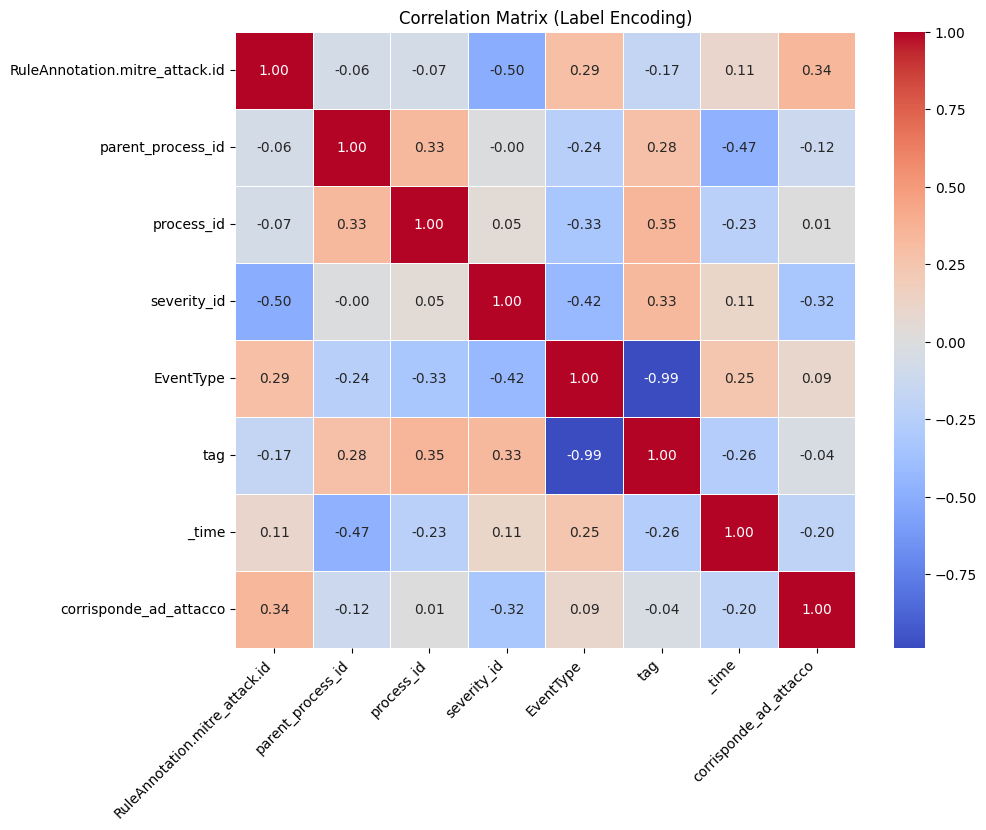

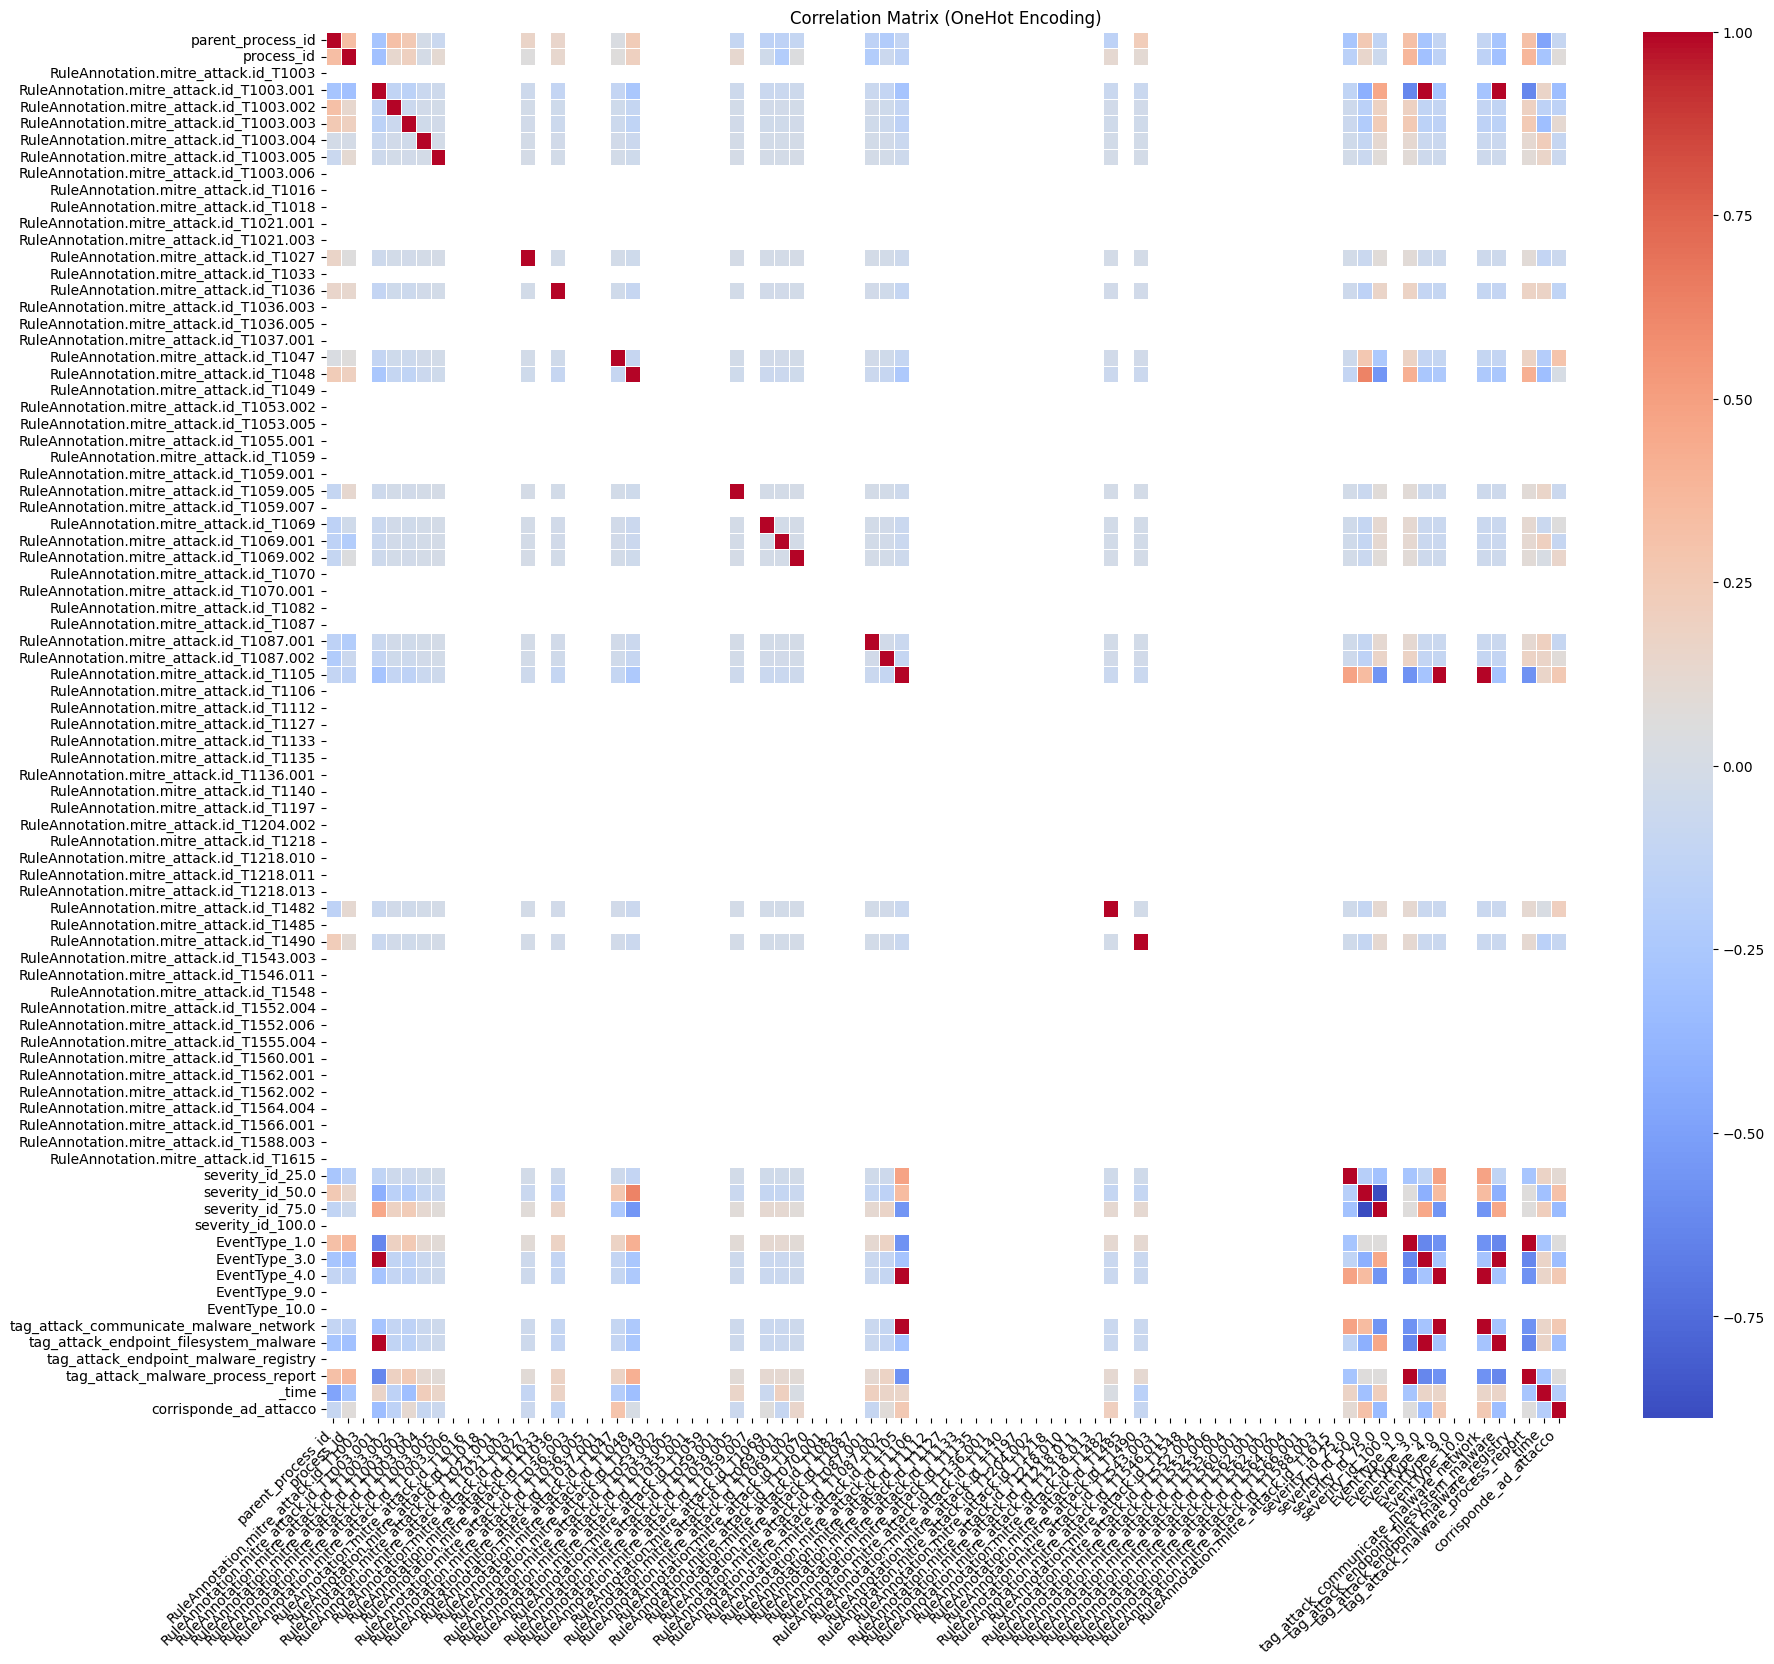

In [14]:
CorrelationMatrixPlots.plot_correlation_matrix(result_df_Le, 'Correlation Matrix (Label Encoding)')
CorrelationMatrixPlots.plot_correlation_matrix_big(result_df_OH, 'Correlation Matrix (OneHot Encoding)')

# ML

In [15]:
from file_py.preprocessing_train_test_split import PreprocessingTrainTestSplit
from file_py.initial_training import InitialTraining
from file_py.hyperparameter_tuning import HyperparameterTuning
from file_py.advanced_models import AdvancedModels
from file_py.deep_learning_model import DeepLearningModel
from file_py.model_evaluator import ModelEvaluator

### OneHot

In [16]:
# Split data
X_train_OH, X_test_OH, y_train_OH, y_test_OH = PreprocessingTrainTestSplit.split_data(result_df_OH, "corrisponde_ad_attacco")

# Initial model training and evaluation
InitialTraining.train_and_evaluate_initial_models(X_train_OH, y_train_OH, X_test_OH, y_test_OH)

# Hyperparameter tuning
best_models_OH = HyperparameterTuning.tune_hyperparameters(X_train_OH, y_train_OH)

# Evaluate best models on test set
evaluator_OH = ModelEvaluator(best_models_OH)
evaluation_results_OH = evaluator_OH.evaluate_models(X_test_OH, y_test_OH)

# Train XGBoost model
AdvancedModels.train_xgboost(X_train_OH, y_train_OH, X_test_OH, y_test_OH)

# Train deep learning model
DeepLearningModel.train_deep_learning_model(X_train_OH, y_train_OH, X_test_OH, y_test_OH)


Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.94      0.81        16
           1       0.83      0.45      0.59        11

    accuracy                           0.74        27
   macro avg       0.77      0.70      0.70        27
weighted avg       0.76      0.74      0.72        27


AdaBoost Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.94      0.86        16
           1       0.88      0.64      0.74        11

    accuracy                           0.81        27
   macro avg       0.83      0.79      0.80        27
weighted avg       0.82      0.81      0.81        27


XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.80      1.00      0.89        16
           1       1.00      0.64      0.78        11

    accuracy                           0.85        27
   macro avg       0.90  

<Sequential name=sequential, built=True>

### Label

In [17]:
# Split data
X_train_Le, X_test_Le, y_train_Le, y_test_Le = PreprocessingTrainTestSplit.split_data(result_df_Le, "corrisponde_ad_attacco")

# Initial model training and evaluation
InitialTraining.train_and_evaluate_initial_models(X_train_Le, y_train_Le, X_test_Le, y_test_Le)

# Hyperparameter tuning
best_models_Le = HyperparameterTuning.tune_hyperparameters(X_train_Le, y_train_Le)

# Evaluate best models on test set
evaluator_Le = ModelEvaluator(best_models_Le)
evaluation_results_Le = evaluator_Le.evaluate_models(X_test_Le, y_test_Le)

# Train XGBoost model
AdvancedModels.train_xgboost(X_train_Le, y_train_Le, X_test_Le, y_test_Le)

# Train deep learning model
DeepLearningModel.train_deep_learning_model(X_train_Le, y_train_Le, X_test_Le, y_test_Le)


Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.94      0.88        16
           1       0.89      0.73      0.80        11

    accuracy                           0.85        27
   macro avg       0.86      0.83      0.84        27
weighted avg       0.86      0.85      0.85        27


AdaBoost Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.94      0.86        16
           1       0.88      0.64      0.74        11

    accuracy                           0.81        27
   macro avg       0.83      0.79      0.80        27
weighted avg       0.82      0.81      0.81        27


XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.94      0.88        16
           1       0.89      0.73      0.80        11

    accuracy                           0.85        27
   macro avg       0.86  

<Sequential name=sequential_1, built=True>